In [ ]:
print("Program Start")

In [ ]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()
print("Done")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

X = mnist["data"]
y = mnist["target"].astype(np.uint8) #cast to integer

#print(X.shape)
#print(y.shape)

k = 50
digit_k = X.to_numpy()[k] #The API of fetch_openml changed between versions. In earlier versions, it returns a numpy.ndarray array. Since 0.24.0 (December 2020), as_frame argument of fetch_openml is set to auto (instead of False as default option earlier) which gives you a pandas.DataFrame for the MNIST data. You can force the data read as a numpy.ndarray by setting as_frame = False

plt.imshow(digit_k.reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
# Create a Test set to set aside by splitting data into training and test sets
# Note that the MNIST dataset is already split into a training set of the first 60,000 images and a test set of the final 10,000 images
X_train = X[0:60000]
y_train = y[0:60000]

X_test = X[60000:]
y_test = y[60000:]

In [ ]:
from sklearn.linear_model import SGDClassifier

#NEURAL NETWORK
y_are_digits = np.array([[(y_i == col) for col in range(0, 10)] for y_i in y])
y_train_are_digits = y_are_digits[:60000]
y_test_are_digits = y_are_digits[60000:]

#BINARY CLASSIFIER
y_train_are_k = [(y_i == y[k]) for y_i in y_train]
y_test_are_k = (y_test == y[k]) # True for all k's, False otherwise (same as line above pretty much but for y_test)

model = SGDClassifier(random_state=42) # "is this the kth digit or not?"
model.fit(X_train, y_train_are_k)

In [ ]:
#Test whether the kth digit is the kth digit. Prediction should return true
model.predict([digit_k]) # remember: digit_k = X.to_numpy()[k] where k is a fixed parameter as in "the kth digit"

In [ ]:
# Time for a neural network!
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy #Logistic Loss function

network = Sequential([
    Dense(units=784, activation='sigmoid'), # [0]: input layer
    Dense(units=16, activation='sigmoid'),  # [1]: hidden layer 1
    Dense(units=14, activation='sigmoid'),  # [2]: hidden layer 2
    Dense(units=10, activation='sigmoid')   # [3]: output layer
])

network.compile(loss=BinaryCrossentropy())

network.fit(X_train, y_train_are_digits)

In [ ]:
def predict(digit):
    digit_probs = network.predict(tf.convert_to_tensor([digit], dtype=tf.float64))[0]
    
    index = 0
    maximum = digit_probs[0]
    for i in range(1, len(digit_probs)):
        prob = digit_probs[i]
        if prob > maximum:
            index = i
            maximum = prob
    
    print(digit_probs)
    print(index)
    return index

predict(digit_k)

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train, y_train_are_k, cv=3, scoring="accuracy") # for binary classifier

**Ok, so at least a 94.96% success rate in classifying the kth digit! However, keep in mind that since there are only 10 possible digits, only 10% of the digits are the kth one. So, a binary classifier that always returns false will be correct 90% of the time**. As such, accuracy is typically not the preferred method of measuring performance

In [ ]:
# Therefore, use a confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_train_cross_val_pred = cross_val_predict(model, X_train, y_train_are_k, cv=3)
confusion_matrix(y_train_are_k, y_train_cross_val_pred) # confusion matrix

In [ ]:
confusion_matrix(y_train_are_k, y_train_are_k) # perfect confusion matrix

In [ ]:
from sklearn.metrics import precision_score
# precision_score(y, yhat)
precision_score(y_train_are_k, y_train_cross_val_pred)

In [ ]:
from sklearn.metrics import recall_score
# recall_score(y, yhat)
recall_score(y_train_are_k, y_train_cross_val_pred)

In [ ]:
# F1 score
from sklearn.metrics import f1_score

f1_score(y_train_are_k, y_train_cross_val_pred)

In [ ]:
y_scores = model.decision_function([digit_k]) # probabilities/scores of digits before decision is made
y_scores

In [ ]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(model, X_train, y_train_are_k, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_are_k, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): # x axis is threshold
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")      # Blue curve is precision
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall/Sensitivity") # Green curve is Recall

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [ ]:
# np.argmax() returns first index of max value in array. In a boolean array, this means the first True value

def threshold_x_precision(x):
    return thresholds[np.argmax(precisions >= x)]

def threshold_x_recall(x):
    return thresholds[np.argmax(recalls >= x)]

threshold_80_precision = threshold_x_precision(0.80)

print(threshold_80_precision)

y_train_pred_thresh80 = [(y_score >= threshold_80_precision) for y_score in y_scores]

In [ ]:
precision_score(y_train_are_k, y_train_pred_thresh80)

In [ ]:
recall_score(y_train_are_k, y_train_pred_thresh80)

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_are_k, y_scores) # roc_curve(y, yhat)

# TPR vs. FPR, so x-axis is FPR (1 - specificity) and y-axis is TPR (recall)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label) # roc curve
    plt.plot([0, 1], [0, 1], "k--") # Dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_are_k, y_scores)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_model, X_train, y_train_are_k, cv=3, method="predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # all rows, column 1
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_are_k, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

### It seems like the Random Forest model is superior to SGD

In [ ]:
roc_auc_score(y_train_are_k, y_scores_forest)

In [ ]:
conf_mx = confusion_matrix(y_train_are_k, y_train_cross_val_pred) # confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [ ]:
# Multilabel Classification
from sklearn.neighbors import KNeighborsClassifier

y_train_small = (y_train <= 3)
y_train_even = (y_train % 2 == 0)
y_multilabel = np.c_[y_train_small, y_train_even]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([digit_k])

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted') # weights each label according to how much data there is on it 

In [4]:
# Create a Test set to set aside by splitting data into training and test sets
# Note that the MNIST dataset is already split into a training set of the first 60,000 images and a test set of the final 10,000 images
X_train = X[0:60000]
y_train = y[0:60000]

X_test = X[60000:]
y_test = y[60000:]

In [8]:
from sklearn.linear_model import SGDClassifier

#NEURAL NETWORK
y_are_digits = np.array([[(y_i == col) for col in range(0, 10)] for y_i in y])
y_train_are_digits = y_are_digits[:60000]
y_test_are_digits = y_are_digits[60000:]

#BINARY CLASSIFIER
y_train_are_k = [(y_i == y[k]) for y_i in y_train]
y_test_are_k = (y_test == y[k]) # True for all k's, False otherwise (same as line above pretty much but for y_test)

model = SGDClassifier(random_state=42) # "is this the kth digit or not?"
model.fit(X_train, y_train_are_k)

SGDClassifier(random_state=42)

In [9]:
#Test whether the kth digit is the kth digit. Prediction should return true
model.predict([digit_k]) # remember: digit_k = X.to_numpy()[k] where k is a fixed parameter as in "the kth digit"

C:\Users\night\Desktop\Projects\AI\ML_Jungle\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [10]:
# Time for a neural network!
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy #Logistic Loss function

network = Sequential([
    Dense(units=784, activation='sigmoid'), # [0]: input layer
    Dense(units=16, activation='sigmoid'),  # [1]: hidden layer 1
    Dense(units=14, activation='sigmoid'),  # [2]: hidden layer 2
    Dense(units=10, activation='sigmoid')   # [3]: output layer
])

network.compile(loss=BinaryCrossentropy())

network.fit(X_train, y_train_are_digits)

1875/1875 [==============================] - 10s 5ms/step - loss: 0.2121


In [34]:
def predict(digit):
    digit_probs = network.predict(tf.convert_to_tensor([digit], dtype=tf.float64))[0]
    
    index = 0
    maximum = digit_probs[0]
    for i in range(1, len(digit_probs)):
        prob = digit_probs[i]
        if prob > maximum:
            index = i
            maximum = prob
    
    print(digit_probs)
    print(index)
    return index

predict(digit_k)

1/1 [==============================] - 0s 12ms/step
[5.1016565e-02 2.9430928e-02 1.6227419e-02 5.9654838e-01 3.5387634e-03
 1.3581099e-01 2.3088166e-02 2.6074395e-04 5.9502374e-02 1.3015240e-02]
3


3

In [35]:
from sklearn.model_selection import cross_val_score

cross_val_score(model, X_train, y_train_are_k, cv=3, scoring="accuracy") # for binary classifier

array([0.9496 , 0.9624 , 0.96275])

**Ok, so at least a 94.96% success rate in classifying the kth digit! However, keep in mind that since there are only 10 possible digits, only 10% of the digits are the kth one. So, a binary classifier that always returns false will be correct 90% of the time**. As such, accuracy is typically not the preferred method of measuring performance

In [39]:
# Therefore, use a confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_score, recall_score

y_train_cross_val_pred = cross_val_predict(model, X_train, y_train_are_k, cv=3)
confusion_matrix(y_train_are_k, y_train_cross_val_pred) # confusion matrix

array([[53477,   392],
       [ 2113,  4018]], dtype=int64)

In [40]:
confusion_matrix(y_train_are_k, y_train_are_k) # perfect confusion matrix

array([[53869,     0],
       [    0,  6131]], dtype=int64)

In [42]:
from sklearn.metrics import precision_score
# precision_score(y, yhat)
precision_score(y_train_are_k, y_train_cross_val_pred)

0.9111111111111111

In [43]:
from sklearn.metrics import recall_score
# recall_score(y, yhat)
recall_score(y_train_are_k, y_train_cross_val_pred)

0.655358016636764

In [45]:
# F1 score
from sklearn.metrics import f1_score

f1_score(y_train_are_k, y_train_cross_val_pred)

0.7623565126648326

In [47]:
y_scores = model.decision_function([digit_k]) # probabilities/scores of digits before decision is made
y_scores

C:\Users\night\Desktop\Projects\AI\ML_Jungle\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2060.09530202])

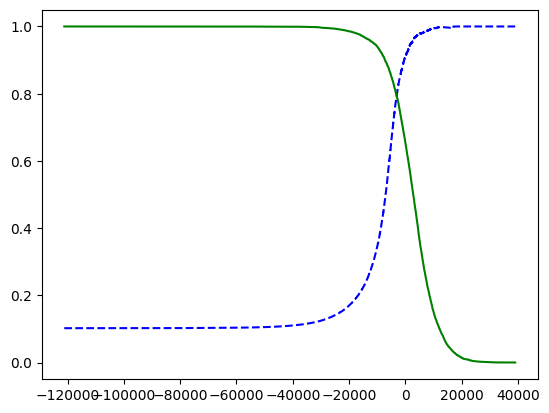

In [48]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(model, X_train, y_train_are_k, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_are_k, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): # x axis is threshold
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")      # Blue curve is precision
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall/Sensitivity") # Green curve is Recall

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [55]:
# np.argmax() returns first index of max value in array. In a boolean array, this means the first True value

def threshold_x_precision(x):
    return thresholds[np.argmax(precisions >= x)]

def threshold_x_recall(x):
    return thresholds[np.argmax(recalls >= x)]

threshold_80_precision = threshold_x_precision(0.80)

print(threshold_80_precision)

y_train_pred_thresh80 = [(y_score >= threshold_80_precision) for y_score in y_scores]

-2960.9420920516286


In [56]:
precision_score(y_train_are_k, y_train_pred_thresh80)

0.8000331071014732

In [57]:
recall_score(y_train_are_k, y_train_pred_thresh80)

0.7882890229978796

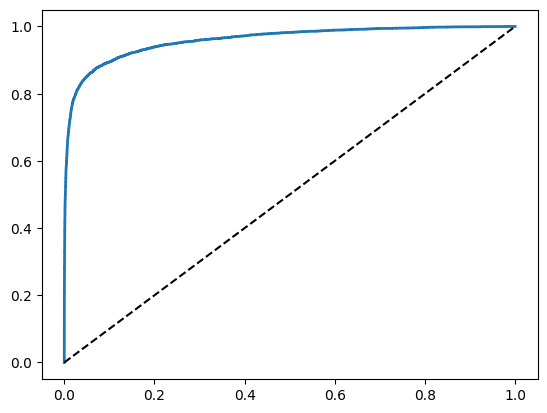

In [58]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_are_k, y_scores) # roc_curve(y, yhat)

# TPR vs. FPR, so x-axis is FPR (1 - specificity) and y-axis is TPR (recall)
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label) # roc curve
    plt.plot([0, 1], [0, 1], "k--") # Dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()

In [59]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_are_k, y_scores)

0.9599243001892759

In [60]:
from sklearn.ensemble import RandomForestClassifier

forest_model = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_model, X_train, y_train_are_k, cv=3, method="predict_proba")

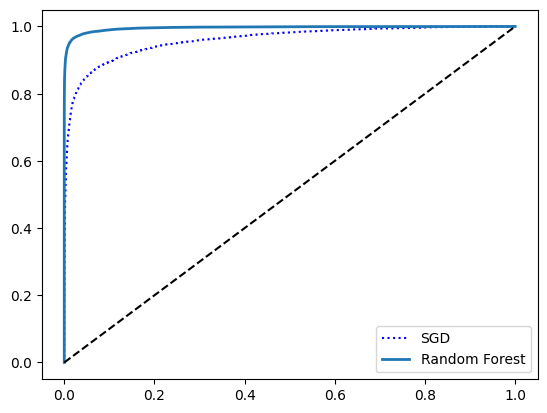

In [61]:
y_scores_forest = y_probas_forest[:, 1] # all rows, column 1
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_are_k, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

### It seems like the Random Forest model is superior to SGD

In [62]:
roc_auc_score(y_train_are_k, y_scores_forest)

0.995864544068936

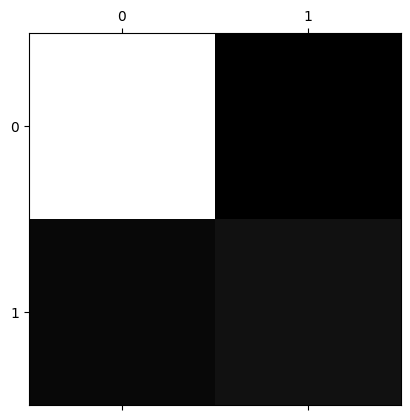

In [63]:
conf_mx = confusion_matrix(y_train_are_k, y_train_cross_val_pred) # confusion matrix
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

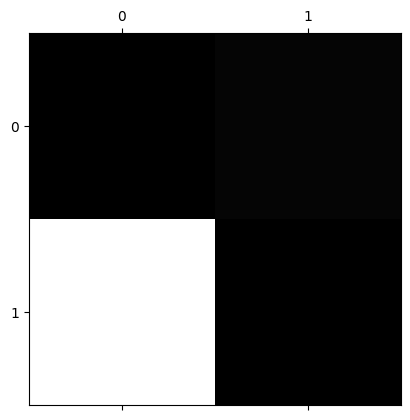

In [64]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [66]:
# Multilabel Classification
from sklearn.neighbors import KNeighborsClassifier

y_train_small = (y_train <= 3)
y_train_even = (y_train % 2 == 0)
y_multilabel = np.c_[y_train_small, y_train_even]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

knn_clf.predict([digit_k])

C:\Users\night\Desktop\Projects\AI\ML_Jungle\env\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[ True, False]])

In [67]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9815242917423209

In [68]:
f1_score(y_multilabel, y_train_knn_pred, average='weighted') # weights each label according to how much data there is on it 

0.9814815233084441